# Experiment: ADLO (v1.c) - ADLO Output fixes
Having identified that there's something wrong with the ADLO Output and associated loss function, this notebook will focus on finding and fixing that problem.

At first we'll use a much simplified model with significantly reduced capacity, because it's faster to train and easier to control in terms of neuron death problems.


In [ ]:
# Clone repo and load its modules
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# start with the revision with problems
!cd repo && git checkout 6c8e34c79e2

# Also checkout ml-learning repo
if os.path.isdir('ml-learning'):
  # discard any local changes and update
  !cd ml-learning && git reset --hard HEAD
  !cd ml-learning && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git ml-learning
!cd ml-learning && git checkout a886b7d060
#!cd ml-learning && git pull

import sys
sys.path.append('repo')
sys.path.append('ml-learning')

from general_utils import display_history
import lds
import slam_models
import slam_data
import slam_operations
import train_observability_toolkit as tot
import train_explainer as te
from importlib import reload
reload(lds)
reload(slam_models)
reload(slam_data)
reload(slam_operations)
reload(tot)
reload(te)

Cloning into 'repo'...
remote: Enumerating objects: 903, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 903 (delta 87), reused 108 (delta 60), pack-reused 753 (from 2)
Receiving objects: 100% (903/903), 103.99 MiB | 44.24 MiB/s, done.
Resolving deltas: 100% (471/471), done.
Note: switching to '6c8e34c79e2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 6c8e34c Detailed examination of layer 35 but no clarity yet.
Cloning into 'ml-learning'..

<module 'train_explainer' from '/content/ml-learning/train_explainer.py'>

In [ ]:
# Load standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as idisplay
import os
import sys
import math
import tqdm
import time
from timeit import default_timer as timer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Add


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")

TensorFlow version: 2.18.0
Keras version: 3.8.0
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
# Training data
# - use model-derived training data to emulate the end of the real training loop
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2.png')

# Load training data
if os.path.isfile('custom-training-data.npz'):
  train_data = slam_data.load_dataset('custom-training-data.npz')
else:
  print(f"Sorry, pre-generated dataset not available, you'll need to generate it.")

  # Load pre-trained model
  raw_model = tf.keras.models.load_model('slam-model-300epochs.keras')

  # generate data
  np.random.seed(0)  # for consistency
  train_data = slam_data.generate_training_data(floorplan, 1000, model=raw_model)
  slam_data.validate_dataset(train_data)

  # save
  slam_data.save_dataset(train_data, 'custom-training-data.npz')

Loaded:
  input_maps:  (1000, 149, 149, 3) x float32
  lds_maps:    (1000, 149, 149) x float32
  output_maps: (1000, 149, 149, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from custom-training-data.npz


## Local tools


In [ ]:
def show_adlo_predictions(model, dataset, num=5, sample_types=None, display_type='plot', **kwargs):
    """
    display_type: one of 'plot', 'list'
    """
    print(sample_types)
    dataset = slam_data.filter_dataset(dataset, num, sample_types)
    inputs, outputs, metadatas = next(iter(dataset.batch(num)))
    preds = model.predict(inputs)

    if display_type == 'plot':
      for map_window, lds_map, ground_truth_map, adlo, metadata, adlo_pred in zip(
              inputs[0], inputs[1], outputs[0], outputs[1], metadatas, preds):
          map_pred = None
          show_adlo_prediction(map_window, lds_map, ground_truth_map, adlo, metadata, map_pred, adlo_pred, **kwargs)
    elif display_type == 'list':
      data = []
      for map_window, lds_map, ground_truth_map, adlo, metadata, adlo_pred in zip(
              inputs[0], inputs[1], outputs[0], outputs[1], metadatas, preds):
          map_pred = None
          adlo_pred_scaled = scale_adlo_prediction(map_window, lds_map, ground_truth_map, adlo, metadata, map_pred, adlo_pred, **kwargs)
          data.append([
              metadata[1].numpy(),  # sample type
              adlo[0].numpy(), adlo_pred[0],  # accept
              adlo[1].numpy(), adlo_pred[1],  # delta x
              adlo[2].numpy(), adlo_pred[2],  # delta y
              adlo[3].numpy(), adlo_pred[3],  # delta orientation
          ])
      columns = ['type', 'accept', 'accept_pred', 'delta_x', 'delta_x_pred', 'delta_y', 'delta_y_pred', 'delta_orientation', 'delta_orientation_pred']
      df = pd.DataFrame(data, columns=columns)
      display(df)
    else:
      raise ValueError(f"Unknown display type: {display_type}")

def scale_adlo_prediction(input_map, lds_map, map_true, adlo, metadata, map_pred, adlo_pred, **kwargs):
    from_logits = kwargs.get('from_logits', True)

    # apply scaling
    if adlo_pred is not None:
        accept = tf.nn.sigmoid(adlo_pred[0]) if from_logits else adlo_pred[0]
        adlo_pred_scaled = tf.stack([accept, adlo_pred[1], adlo_pred[2], adlo_pred[3]], axis=0)
    else:
        adlo_pred_scaled = None

    return adlo_pred_scaled

def show_adlo_prediction(input_map, lds_map, map_true, adlo, metadata, map_pred, adlo_pred, **kwargs):
    """
    :param input_map:
    :param lds_map:
    :param map_true:
    :param adlo:
    :param metadata:
    :param map_pred:
    :param adlo_pred:

    Keyword args:
      show_classes: one of 'none' (or False), 'all' (or True), 'pred'
    """
    from_logits = kwargs.get('from_logits', True)
    show_classes = kwargs.get('show_classes', 'none')
    map_size = np.array([input_map.shape[1], input_map.shape[0]])
    n_classes = input_map.shape[-1]

    # apply scaling
    if adlo_pred is not None:
        accept = tf.nn.sigmoid(adlo_pred[0]) if from_logits else adlo_pred[0]
        adlo_pred_scaled = tf.stack([accept, adlo_pred[1], adlo_pred[2], adlo_pred[3]], axis=0)
    else:
        adlo_pred_scaled = None

    # Log details that are not so great in visual form
    print(f"adlo-true: {adlo}")
    print(f"adlo-pred: {adlo_pred_scaled}")
    print(f"metadata:  {metadata}")

    # Calculate total number of plots to display
    cols = 0
    cols = cols + (1 if input_map is not None else 0)
    cols = cols + (1 if lds_map is not None else 0)
    cols = cols + (1 if map_true is not None else 0)

    # Show plots
    plt.figure(figsize=(10, 2))  # limits by row height
    i = iter(range(1, cols+1))

    if input_map is not None:
        plt.subplot(1, cols, next(i))
        plt.title('Map')
        plt.imshow(input_map)
        plt.axis('off')
        if adlo is not None and not adlo[0]:
            # to be rejected so just add cross through map
            plt.plot([0, map_size[0] - 1], [0, map_size[1] - 1], c='y')
            plt.plot([0, map_size[0] - 1], [map_size[1] - 1, 0], c='y')
        elif adlo is not None:
            # show adlo relative to centre dot
            centre = map_size / 2
            error_loc = centre + adlo[1:3] * map_size
            angle_loc = error_loc + np.array([np.cos(adlo[3] * np.pi), np.sin(adlo[3] * np.pi)]) * 50
            plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
            plt.scatter(centre[0], centre[1], c='k', s=50)
            plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

    if lds_map is not None:
        plt.subplot(1, cols, next(i))
        plt.title('LDS')
        plt.imshow(lds_map, cmap='gray')
        plt.axis('off')

    if map_true is not None:
        plt.subplot(1, cols, next(i))
        plt.title('Ground Truth')
        plt.imshow(map_true)
        plt.axis('off')
        if adlo_pred_scaled is not None:
            centre = map_size / 2
            error_loc = centre + adlo_pred_scaled[1:3] * map_size
            angle = adlo_pred_scaled[3] * np.pi
            angle_loc = error_loc + np.array([np.cos(angle), np.sin(angle)]) * 50
            plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
            plt.scatter(centre[0], centre[1], c='k', s=50)
            plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

    plt.show()


## Simple Model and a Baseline
We'll start with a signicantly simpler model, with significantly reduced capacity.

We'll use the MSE loss as a baseline-of-sorts for comparison to.

In [ ]:
def pad_block(x, input_size):
    """
    Works out if padding is required and applies it if needed.
    Args:
      x: image or map tensor (B,H,W,...)
      input_size: size of input (H,W,...)
    Returns:
      padded tensor (B,H+pad_h,W+pad_w,...), total padded width, total padded height
    """
    pad_h = 64 - input_size[0] % 64
    pad_w = 64 - input_size[1] % 64
    if pad_h > 0 or pad_w > 0:
        padded = ZeroPadding2D(padding=((pad_h//2, pad_h-pad_h//2), (pad_w//2, pad_w-pad_w//2)))(x)
    else:
        padded = x
    return padded, pad_w, pad_h

def adlo_model(map_shape, conv_filters=32, adlo_units=256, dropout_rate=0.1, loss=None, **kwargs):
    merge_mode = kwargs.get('merge_mode', 'concat')
    output_logits = kwargs.get('output_logits', True)
    do_compile = kwargs.get('compile', False)

    # Sanity check
    if np.size(map_shape) != 3:
        raise ValueError(f"Map shape must have 3 dims, found {np.size(map_shape)}")

    # Prepare map input
    # (pad so it's a multiple of our down/up-scaling blocks)
    map_input = Input(shape=map_shape, name='map_input')
    map_down, pad_w, pad_h = slam_models.pad_block(map_input, map_shape)
    n_classes = map_shape[2]

    # Prepare LDS input
    # (convert from (B,H,W) to (B,H,W,1) to make later work easier)
    # (pad so it's a multiple of our down/up-scaling blocks)
    lds_shape = (map_shape[0], map_shape[1], 1)
    lds_input = Input(shape=(map_shape[0], map_shape[1]), name='lds_input')  # raw input omits channels axis
    lds_down = tf.keras.layers.Reshape(target_shape=lds_shape)(lds_input)
    lds_down, _, _ = slam_models.pad_block(lds_down, lds_shape)

    drate = dropout_rate

    # Map downsampling input arm
    # (each block here returns two outputs (downsampled, convolved-only),
    #  the latter is used for skip-connections)
    map_down = Conv2D(filters=conv_filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(map_down)
    map_down = MaxPooling2D(pool_size=(2, 2))(map_down)
    map_down = Dropout(rate=drate)(map_down)
    map_down = Conv2D(filters=conv_filters * 2, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(map_down)
    map_down = MaxPooling2D(pool_size=(2, 2))(map_down)
    map_down = Dropout(rate=drate)(map_down)
    map_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(map_down)
    map_down = MaxPooling2D(pool_size=(2, 2))(map_down)
    map_down = Dropout(rate=drate)(map_down)
    map_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(map_down)
    map_down = MaxPooling2D(pool_size=(2, 2))(map_down)
    map_down = Dropout(rate=drate)(map_down)
    map_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(map_down)
    map_down = MaxPooling2D(pool_size=(2, 2))(map_down)
    map_down = Dropout(rate=drate)(map_down)
    map_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(map_down)
    map_down = MaxPooling2D(pool_size=(2, 2))(map_down)
    map_down = Dropout(rate=drate)(map_down)
    # reduce before concatenating
    map_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(map_down)
    map_down = Dropout(rate=drate)(map_down)

    # LDS downsampling input arm
    lds_down = Conv2D(filters=conv_filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(lds_down)
    lds_down = MaxPooling2D(pool_size=(2, 2))(lds_down)
    lds_down = Dropout(rate=drate)(lds_down)
    lds_down = Conv2D(filters=conv_filters * 2, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(lds_down)
    lds_down = MaxPooling2D(pool_size=(2, 2))(lds_down)
    lds_down = Dropout(rate=drate)(lds_down)
    lds_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(lds_down)
    lds_down = MaxPooling2D(pool_size=(2, 2))(lds_down)
    lds_down = Dropout(rate=drate)(lds_down)
    lds_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(lds_down)
    lds_down = MaxPooling2D(pool_size=(2, 2))(lds_down)
    lds_down = Dropout(rate=drate)(lds_down)
    lds_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(lds_down)
    lds_down = MaxPooling2D(pool_size=(2, 2))(lds_down)
    lds_down = Dropout(rate=drate)(lds_down)
    lds_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(lds_down)
    lds_down = MaxPooling2D(pool_size=(2, 2))(lds_down)
    lds_down = Dropout(rate=drate)(lds_down)
    # reduce before concatenating
    lds_down = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(lds_down)
    lds_down = Dropout(rate=drate)(lds_down)

    # Bottom layer
    # (combine both input arms, apply some final convolutions, leave at same scale)
    bottom = Concatenate(axis=3)([map_down, lds_down])
    bottom = Conv2D(filters=conv_filters * 4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(bottom)
    bottom = Dropout(rate=max(0.5, drate))(bottom)

    # ADLO output
    adlo = Conv2D(filters=4, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(bottom)
    adlo = Flatten()(adlo)
    adlo = Dense(units=256, activation='relu')(adlo)
    adlo = Dropout(rate=drate)(adlo)
    adlo = Dense(units=16, activation='relu')(adlo)
    adlo = Dropout(rate=drate)(adlo)
    adlo_out = Dense(units=4, name='adlo_output')(adlo)

    model = tf.keras.Model(inputs=[map_input, lds_input], outputs=[adlo_out])

    if do_compile:
        loss = (
            loss
        )
        metrics = {
            'adlo_output': [tf.keras.metrics.MeanSquaredError(name='mse'),
                            slam_models.AcceptAccuracy(),
                            slam_models.LocationError(),
                            slam_models.OrientationError()]
        }
        model.compile(optimizer='adam', loss=loss, metrics=metrics)

    print(f"Prepared SLAM model")
    print(f"  Map shape:        {map_shape} + padding ({pad_h}, {pad_w}, 0)")
    print(f"  Skip-connections: {merge_mode}")
    print(f"  Output scaling:   {'logits' if output_logits else 'scaled'}")
    print(f"  Loss func:        {loss}")
    print(f"  Layers:           {len(model.layers)}")
    print(f"  Inputs:           {model.inputs}")
    print(f"  Outputs:          {model.outputs}")
    print(f"  Output names:     {model.output_names}")
    print(f"  Compiled:         {do_compile}")
    return model

def for_adlo_training(inputs, outputs, metadata):
    (map_input, lds_input), (map_output, adlo_output) = inputs, outputs
    return (map_input, lds_input), adlo_output

Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Loss func:        mse
  Layers:           55
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_52>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True


Epoch     2 - 20.02s/epoch: accept_accuracy: 0.7330  loc_error: 0.2302  loss: 0.1491  mse: 0.1491  orientation_error: 0.2307  
Epoch     4 - 3.70s/epoch: accept_accuracy: 0.7410  loc_error: 0.1842  loss: 0.1039  mse: 0.1039  orientation_error: 0.2224  
Epoch     6 - 3.73s/epoch: accept_accuracy: 0.7410  loc_error: 0.1546  loss: 0.0886  mse: 0.0886  orientation_error: 0.2130  
Epoch     8 - 3.68s/epoch: accept_accuracy: 0.7410  loc_error: 0.1482  loss: 0.0822  mse: 0.0822  orientation_error: 0.2104  
Epoch    10 - 3.65s/epoch: accept_accuracy: 0.7410  loc_error: 0.1424  loss: 0.0773  mse: 0.0773  orientation_error: 0.2106  
Epoch    12 - 3.79s/epoch: accept_accuracy: 0.7410  loc_error: 0.1379  loss: 0.0731  mse: 0.0731  orientation_error: 0.2037  
Epoch    14 - 3.75s/epoch: accept_accuracy: 0.7410  loc_error: 0.1325  loss: 0.0694  mse: 0.0694  orientation_error: 0.2055  
Epoch    16 - 3.73s/epoch: accept_accuracy: 0.7410  loc_error: 0.1306  loss: 0.0647  mse: 0.0647  orientation_error: 

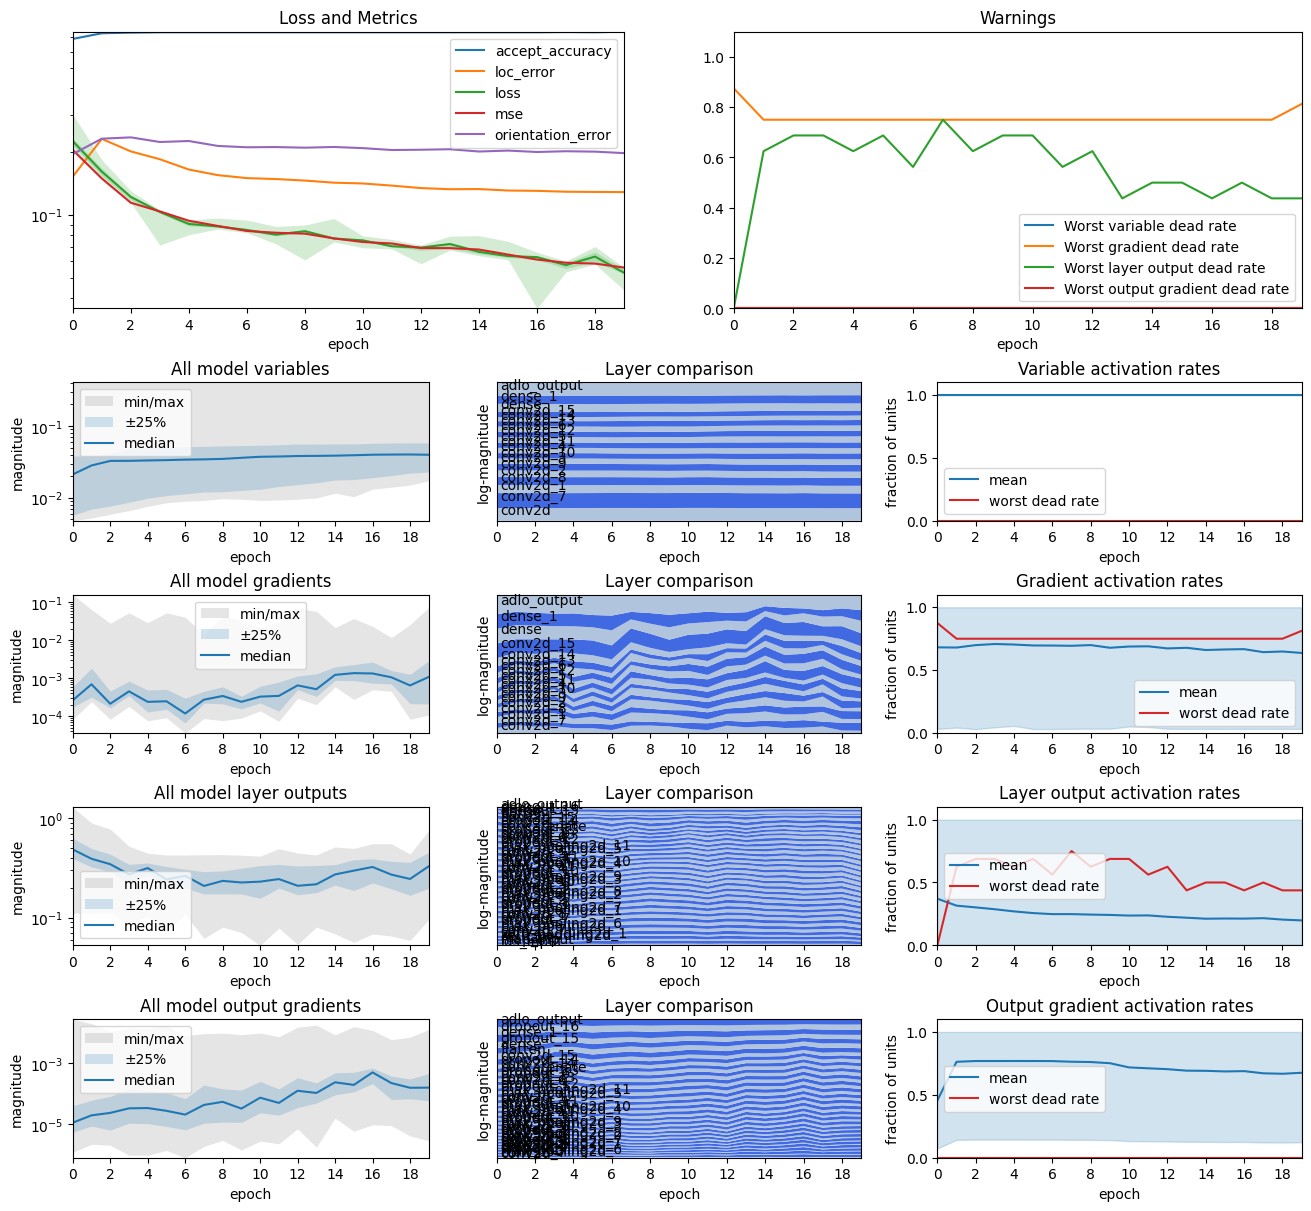

In [ ]:
# Short baseline run (20 epochs)
reload(slam_models)
np.random.seed(42)
tf.random.set_seed(42)
epochs = 20
batch_size = 32
tf.config.run_functions_eagerly(False)
map_shape = next(iter(train_data))[0][0].shape
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)
model = adlo_model(map_shape, compile=True, dropout_rate=0.1, loss='mse')

per_step=False
variables = tot.VariableHistoryCallback(per_step=per_step)
outputs = tot.LayerOutputHistoryCallback(per_step=per_step)
gradients = tot.GradientHistoryCallback(per_step=per_step)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=per_step)
model_history = tot.fit(model, model_train_data, epochs=epochs, verbose=0, callbacks=[variables, outputs, gradients, output_gradients, tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=per_step)])

tot.plot_history_overview([model_history, variables, gradients, outputs, output_gradients])

Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Loss func:        <slam_models.ADLOLoss object at 0x7c3b77572a50>
  Layers:           55
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_105>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True


Epoch     2 - 18.35s/epoch: accept_accuracy: 0.7410  loc_error: 0.1088  loss: 1.2826  mse: 0.2015  orientation_error: 0.1874  
Epoch     4 - 3.74s/epoch: accept_accuracy: 0.7410  loc_error: 0.1089  loss: 1.2763  mse: 0.1822  orientation_error: 0.1874  
Epoch     6 - 3.69s/epoch: accept_accuracy: 0.7410  loc_error: 0.1088  loss: 1.2593  mse: 0.1649  orientation_error: 0.1875  
Epoch     8 - 3.75s/epoch: accept_accuracy: 0.7410  loc_error: 0.1088  loss: 1.2484  mse: 0.1497  orientation_error: 0.1874  
Epoch    10 - 3.59s/epoch: accept_accuracy: 0.7410  loc_error: 0.1088  loss: 1.2385  mse: 0.1366  orientation_error: 0.1875  
Epoch    12 - 3.66s/epoch: accept_accuracy: 0.7410  loc_error: 0.1089  loss: 1.2330  mse: 0.1255  orientation_error: 0.1874  
Epoch    14 - 3.58s/epoch: accept_accuracy: 0.7410  loc_error: 0.1088  loss: 1.2236  mse: 0.1158  orientation_error: 0.1875  
Epoch    16 - 3.58s/epoch: accept_accuracy: 0.7410  loc_error: 0.1088  loss: 1.2193  mse: 0.1076  orientation_error: 

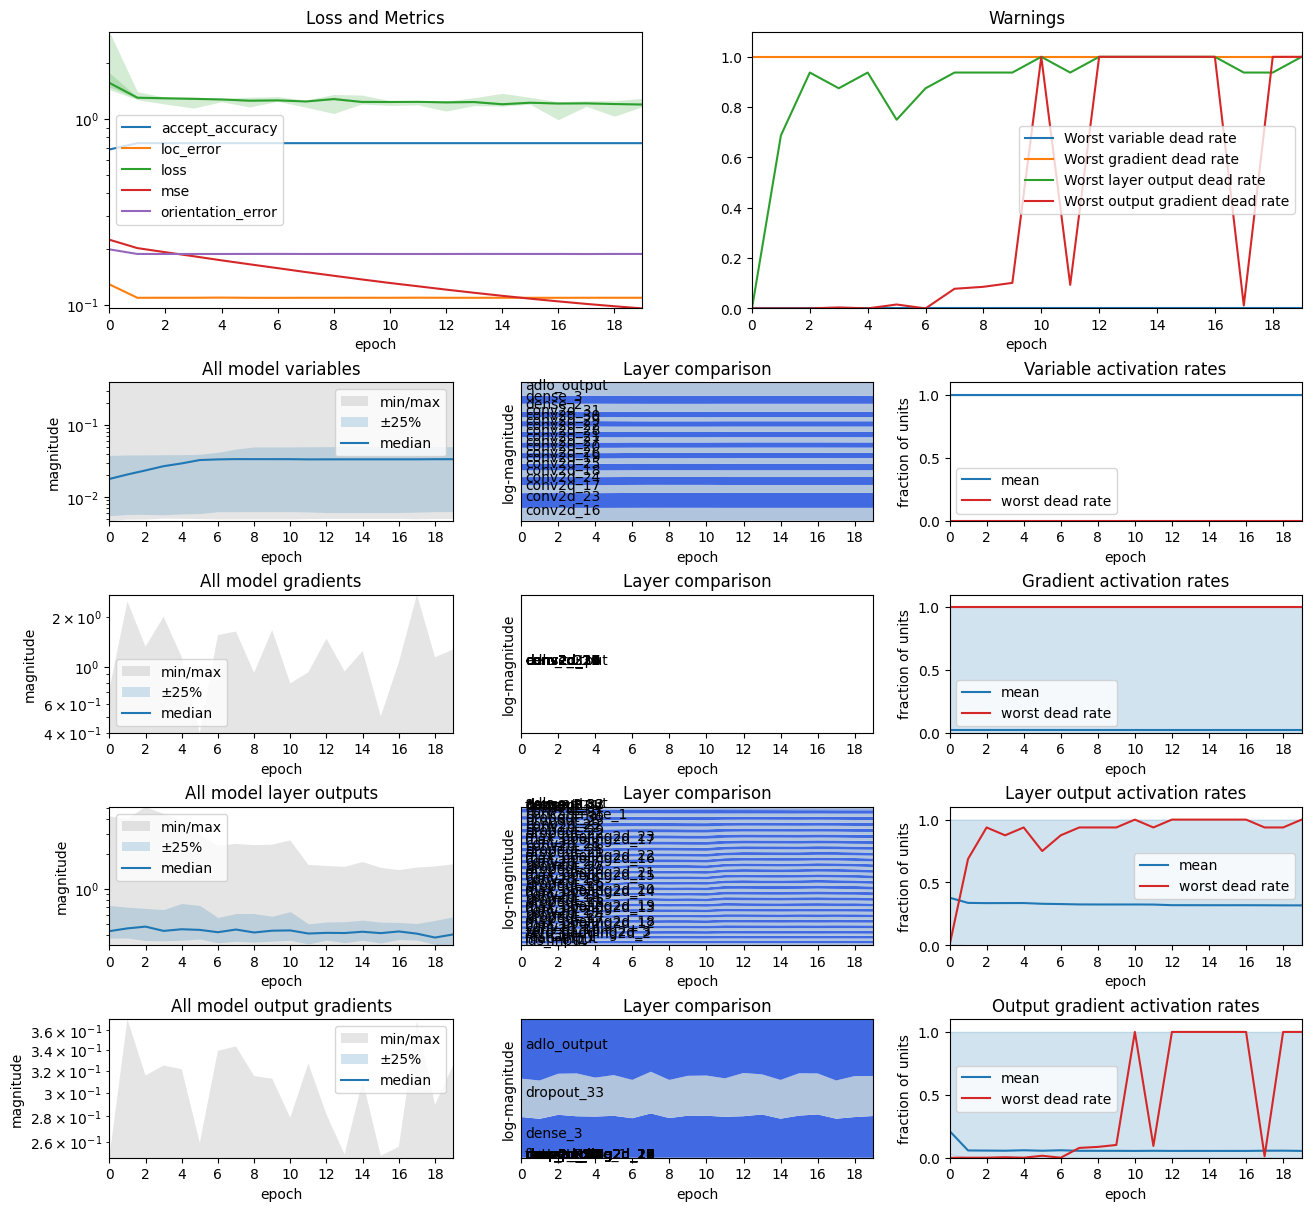

In [ ]:
# Using existing ADLOLoss
reload(slam_models)
np.random.seed(42)
tf.random.set_seed(42)
epochs = 20
batch_size = 32
tf.config.run_functions_eagerly(False)
map_shape = next(iter(train_data))[0][0].shape
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)
model = adlo_model(map_shape, compile=True, dropout_rate=0.1, loss=slam_models.ADLOLoss(from_logits=True))

per_step=False
variables = tot.VariableHistoryCallback(per_step=per_step)
outputs = tot.LayerOutputHistoryCallback(per_step=per_step)
gradients = tot.GradientHistoryCallback(per_step=per_step)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=per_step)
model_history = tot.fit(model, model_train_data, epochs=epochs, verbose=0, callbacks=[variables, outputs, gradients, output_gradients, tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=per_step)])

tot.plot_history_overview([model_history, variables, gradients, outputs, output_gradients])

## ADLOLoss validation
Let's set ourselves up to validate the loss function directly.
This will eventually turn into a unit test.

In [ ]:
# First, let's see how a standard loss class behaves
y_true = np.array([1, 0.0, 0.0, 0.0])
y_pred = np.array([1, 0.0, 0.0, 0.0])

y_true = np.tile(y_true, (32, 1))
y_pred = np.tile(y_pred, (32, 1))

print(f"y_true: {y_true.shape}")
print(f"y_pred: {y_pred.shape}")

losses = tf.keras.losses.MeanSquaredError().call(y_true, y_pred)
print(f"losses: {losses if tf.size(losses) == 1 else losses.shape} - {losses}")

loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
print(f"loss: {loss}")

y_true: (32, 4)
y_pred: (32, 4)
losses: (32,) - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
loss: 0.0


In the following, the original output was as follows. The 0.313 is due to the cross-entropy loss against the accept field, but the `losses` field should be a tensor, not a scalar:
```
y_true: (32, 4)
y_pred: (32, 4)
losses: 0.3132616877555847
loss: 0.3132616877555847
```

In [ ]:
# y_true and y_pred have shape: (B,4)
#  - [0] accept:      0 or 1
#  - [1] delta-x:     -0.5 .. +0.5  - should be ignored if y_true.accept == 0
#  - [2] delta-y:     -0.5 .. +0.5  - should be ignored if y_true.accept == 0
#  - [3] delta-angle: -1.0 .. +1.0  - should be ignored if y_true.accept == 0
y_true = np.array([1, 0.0, 0.0, 0.0])
y_pred = np.array([1, 0.0, 0.0, 0.0])

y_true = np.tile(y_true, (32, 1))
y_pred = np.tile(y_pred, (32, 1))

print(f"y_true: {y_true.shape}")
print(f"y_pred: {y_pred.shape}")

losses = slam_models.ADLOLoss(from_logits=True).call(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))
print(f"losses: {losses if tf.size(losses) == 1 else losses.shape}")

loss = slam_models.ADLOLoss(from_logits=True)(y_true, y_pred)
print(f"loss: {loss}")

y_true: (32, 4)
y_pred: (32, 4)
losses: 0.3132616877555847
loss: 0.3132616877555847


In [ ]:
# Notice that CE Loss is assymetrically skewed, giving greater loss to false positives than to false-negatives, and giving the same loss to a true-negative than it gives for a false-negative.
# Apparently this doesn't tend to be a problem for balanced data.
# It can be a problem if the training data is skewed with only a few positive examples, but thankfully my data is more skewed in the other direction, so it should be fine.
for y_true, y_pred in [(1.0, 1.0), (1.0, 0.0), (0.0, 0.0), (0.0, 1.0)]:
  print(f"y_true: {y_true}, y_pred: {y_pred}, ce-loss: {tf.keras.losses.binary_crossentropy([y_true], [y_pred], from_logits=True, axis=-1).numpy()}")

y_true: 1.0, y_pred: 1.0, ce-loss: 0.3132616877555847
y_true: 1.0, y_pred: 0.0, ce-loss: 0.6931471824645996
y_true: 0.0, y_pred: 0.0, ce-loss: 0.6931471824645996
y_true: 0.0, y_pred: 1.0, ce-loss: 1.3132617473602295


In [ ]:
# fixing output type - should be a tensor
from tensorflow.python.keras.utils import losses_utils
class ADLOLoss(tf.keras.losses.Loss):
    """
    Custom loss for ADLO output.
    By default, assumes output_logits=True in model.

    Assumes:
      y_true: (B,4), scaled
      y_pred: (B,4), accept part logit or scaled, and DLO parts scaled always
    """
    def __init__(self, name="adlo_loss", from_logits=True, dlo_encoding='linear/importance', reduction='sum_over_batch_size'):
        """
        Args:
          from_logits: bool, must be supplied the same as for ADLOActivation.
          reduction: ignored. Required for deserialization.
        """
        super().__init__(name=name, reduction=reduction)
        self._from_logits = from_logits
        self._dlo_encoding = dlo_encoding

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        # binary cross-entropy loss for accept
        # - note: important to retain feature dim or binary_crossentropy will return a scalar
        accept_true = y_true[:, 0:1]  # shape: (B,1)
        accept_pred = y_pred[:, 0:1]  # shape: (B,1)
        accept_losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=self._from_logits, axis=-1)
        #print(f"   accept_true: {accept_true.shape}, accept_pred: {accept_pred.shape}, accept_losses: {accept_losses.shape}")

        # DLO mask - simply: include if accept_true, exclude otherwise
        mask = accept_true[:,0]  # important here to drop the feature dim
        #print(f"   mask: {mask.shape}")

        # loss for delta x, y, and orientation
        dlo_true = y_true[:, 1:4]  # shape: (B,3)
        dlo_pred = y_pred[:, 1:4]  # shape: (B,3)
        if self._dlo_encoding.endswith('/log-cosh'):
            dlo_losses = tf.math.log(tf.cosh(dlo_pred - dlo_true))
        elif self._dlo_encoding.endswith('/linear'):
            dlo_losses = tf.math.abs(dlo_pred - dlo_true)
        elif self._dlo_encoding.endswith('/importance'):
            dlo_losses = tf.math.abs(dlo_pred - dlo_true)

            # For importance calculation we first convert dlo_true's value ranges as follows:
            #   delta-x:     abs(-0.5..+0.5) * 2 -> 0..1
            #   delta-y:     abs(-0.5..+0.5) * 2 -> 0..1
            #   delta-angle: abs(-1.0..+1.0)     -> 0..1
            # As a computationally efficient approximation of a L2 distance that is biased towards
            # giving higher importance, we simply take the max of delta-x and delta-y (ie: the L-inf norm),
            # and combine back with the unchanged third column.
            # This gives everything in range 0.0 to 1.0. Finally, we apply an importance scaling
            # s.t.
            #   y_true ~= 0   -> 4.0x loss   <-- more importance when very close to zero
            #   y_true ~= 0.2 -> 2.5x loss   <-- still high importance when near zero
            #   y_true ~= 1.0 -> 1.0x loss   <-- drops to normal loss at edges
            scaled_dist_true = tf.reduce_max(tf.abs(dlo_true[:, 0:2]), axis=-1, keepdims=True) * 2  # (B,1) x 0..1
            scaled_dlo_true = tf.concat([scaled_dist_true, scaled_dist_true, tf.abs(dlo_true[:, 2:])],
                                        axis=-1)  # (B,3) x 0..1
            dlo_importance = 4 / (1 + 3 * scaled_dlo_true)  # (B,3) x 4..1
            dlo_losses *= dlo_importance
        else:
            raise ValueError(f"Unknown dlo encoding: {self._dlo_encoding}")

        dlo_losses = tf.reduce_sum(dlo_losses, axis=-1)  # shape: (B,)
        dlo_losses = dlo_losses * mask
        #print(f"   dlo_true: {dlo_true.shape}, dlo_pred: {dlo_pred.shape}, dlo_losses: {dlo_losses.shape}")

        return accept_losses + dlo_losses  # shape: scalar

    def get_config(self):
        config = super(ADLOLoss, self).get_config()
        config.update({
            "from_logits": self._from_logits,
            "dlo_encoding": self._dlo_encoding
        })
        return config

In [ ]:
# Check the most basic conditions
# condition[] = (name, y_true row, y_pred row, losses_true row)
def ce_val(y_true_val, y_pred_val):
  return tf.keras.losses.binary_crossentropy([y_true_val], [y_pred_val], from_logits=True, axis=-1).numpy()
conditions = [
    ("true-pos accept",
     np.array([1, 0.0, 0.0, 0.0]), np.array([1, 0.0, 0.0, 0.0]), ce_val(1.0, 1.0)),
    ("true-neg accept",
     np.array([0, 0.0, 0.0, 0.0]), np.array([0, 0.0, 0.0, 0.0]), ce_val(0.0, 0.0)),
    ("ignores DLO on reject",
     np.array([0, 0.0, 0.0, 0.0]), np.array([0, 0.1, 2.0, -0.3]), ce_val(0.0, 0.0)),
    ("ignores DLO on reject",
     np.array([0, 0.1, 2.0, -0.3]), np.array([0, 0.0, 0.0, 0.0]), ce_val(0.0, 0.0)),
    ("diff from x=0",
     np.array([1, 0.0, 0.0, 0.0]), np.array([1, 1.0, 0.0, 0.0]), ce_val(1.0, 1.0) + 1.0*4.0),
    ("diff from x,y=0",
     np.array([1, 0.0, 0.0, 0.0]), np.array([1, 1.0, 1.0, 0.0]), ce_val(1.0, 1.0) + 2*1.0*4.0),
    ("same x,y,angle",
     np.array([1, 1.0, 0.5, 0.75]), np.array([1, 1.0, 0.5, 0.75]), ce_val(1.0, 1.0)),
    ("diff from x=0.5",
     np.array([1, 0.5, 0.0, 0.0]), np.array([1, 0.0, 0.0, 0.0]), ce_val(1.0, 1.0) + 0.5*1.0),
    ("diff from x=0.5,-y=0.5",
     np.array([1, 0.5, -0.5, 0.0]), np.array([1, 0.0, 0.0, 0.0]), ce_val(1.0, 1.0) + 2*0.5*1.0),
    ("diff from a=0.0",
     np.array([1, 0.0, 0.0, 0.0]), np.array([1, 0.0, 0.0, -1.0]), ce_val(1.0, 1.0) + 1.0*4.0),
    ("diff from x=0.5,y=0.0,a=-1.0",
     np.array([1, 0.5, 0.0, -1.0]), np.array([1, 0.0, -0.25, 0.0]), ce_val(1.0, 1.0) + 0.5*1.0 + 0.25*1.0 + 1.0*1.0),
]

has_errors = False
for name, y_true, y_pred, losses_true in conditions:
  y_true = np.tile(y_true, (32, 1))
  y_pred = np.tile(y_pred, (32, 1))
  losses_true = np.tile(losses_true, (32, 1))
  loss_true = np.mean(losses_true)

  print(f"{name}:")
  print(f"  y_true:      {y_true.shape} - first row: {y_true[0]}")
  print(f"  y_pred:      {y_pred.shape} - first row: {y_pred[0]}")
  print(f"  losses_true: {losses_true.shape} - first_row: {losses_true[0]}")
  print(f"  loss_true:   {loss_true}")

  losses = ADLOLoss(from_logits=True).call(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))
  print(f"  losses_pred: {losses if tf.size(losses) == 1 else losses.shape} - first row: {losses[0]}")

  loss = ADLOLoss(from_logits=True)(y_true, y_pred)
  print(f"  loss_pred:   {loss}")

  if not np.allclose(losses, losses_true):
    print(f"  Error: losses not correct - diff = {math.sqrt(tf.reduce_mean(tf.keras.losses.MSE(losses_true, losses)))}")
    has_errors = True
  if not np.allclose(loss, loss_true):
    print(f"  Error: loss not correct - diff = {loss - loss_true}")
  print()

assert not has_errors, "Errors found"
print(f"No errors.")

true-pos accept:
  y_true:      (32, 4) - first row: [1. 0. 0. 0.]
  y_pred:      (32, 4) - first row: [1. 0. 0. 0.]
  losses_true: (32, 1) - first_row: [0.3132617]
  loss_true:   0.3132616877555847
  losses_pred: (32,) - first row: 0.3132616877555847
  loss_pred:   0.3132616877555847

true-neg accept:
  y_true:      (32, 4) - first row: [0. 0. 0. 0.]
  y_pred:      (32, 4) - first row: [0. 0. 0. 0.]
  losses_true: (32, 1) - first_row: [0.6931472]
  loss_true:   0.6931471824645996
  losses_pred: (32,) - first row: 0.6931471824645996
  loss_pred:   0.6931471824645996

ignores DLO on reject:
  y_true:      (32, 4) - first row: [0. 0. 0. 0.]
  y_pred:      (32, 4) - first row: [ 0.   0.1  2.  -0.3]
  losses_true: (32, 1) - first_row: [0.6931472]
  loss_true:   0.6931471824645996
  losses_pred: (32,) - first row: 0.6931471824645996
  loss_pred:   0.6931471824645996

ignores DLO on reject:
  y_true:      (32, 4) - first row: [ 0.   0.1  2.  -0.3]
  y_pred:      (32, 4) - first row: [0. 0. 0

In [ ]:
# check combinations of conditions
y_true = np.stack([y_true for name, y_true, y_pred, losses_true in conditions], axis=0)
y_pred = np.stack([y_pred for name, y_true, y_pred, losses_true in conditions], axis=0)
losses_true = np.stack([losses_true for name, y_true, y_pred, losses_true in conditions], axis=0)
loss_true = np.mean(losses_true)

print(f"  y_true:      {y_true.shape}")
print(f"  y_pred:      {y_pred.shape}")
print(f"  losses_true: {losses_true.shape}")
print(f"  loss_true:   {loss_true}")

losses = ADLOLoss(from_logits=True).call(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))
print(f"  losses_pred: {losses if tf.size(losses) == 1 else losses.shape} - {losses}")

loss = ADLOLoss(from_logits=True)(y_true, y_pred)
print(f"  loss_pred:   {loss}")

if not np.allclose(losses, losses_true):
  print(f"  Error: losses not correct - diff = {math.sqrt(tf.reduce_mean(tf.keras.losses.MSE(losses_true, losses)))}")
  has_errors = True
if not np.allclose(loss, loss_true):
  print(f"  Error: loss not correct - diff = {loss - loss_true}")

assert not has_errors, "Errors found"
print(f"No errors.")


  y_true:      (11, 4)
  y_pred:      (11, 4)
  losses_true: (11,)
  loss_true:   2.166866822676225
  losses_pred: (11,) - [0.3132617 0.6931472 0.6931472 0.6931472 4.3132615 8.313262  0.3132617
 0.8132617 1.3132617 4.3132615 2.0632617]
  loss_pred:   2.1668665409088135
No errors.


## Revised ADLOLoss
Now that we have a better idea of what the ADLOLoss function should be.
Let's try it out during training.

In [ ]:
class ADLOLoss(tf.keras.losses.Loss):
    """
    Custom loss for ADLO output.
    By default, assumes output_logits=True in model.

    Assumes:
      y_true: (B,4), scaled
      y_pred: (B,4), accept part logit or scaled, and DLO parts scaled always
    """
    def __init__(self, name="adlo_loss", from_logits=True, dlo_encoding='linear/importance', reduction='sum_over_batch_size'):
        """
        Args:
          from_logits: bool, must be supplied the same as for ADLOActivation.
          reduction: ignored. Required for deserialization.
        """
        super().__init__(name=name, reduction=reduction)
        self._from_logits = from_logits
        self._dlo_encoding = dlo_encoding

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        # binary cross-entropy loss for accept
        # - note: important to retain feature dim or binary_crossentropy will return a scalar
        accept_true = y_true[:, 0:1]  # shape: (B,1)
        accept_pred = y_pred[:, 0:1]  # shape: (B,1)
        accept_losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=self._from_logits, axis=-1)
        #print(f"   accept_true: {accept_true.shape}, accept_pred: {accept_pred.shape}, accept_losses: {accept_losses.shape}")

        # DLO mask - simply: include if accept_true, exclude otherwise
        mask = accept_true[:,0]  # important here to drop the feature dim
        #print(f"   mask: {mask.shape}")

        # loss for delta x, y, and orientation
        dlo_true = y_true[:, 1:4]  # shape: (B,3)
        dlo_pred = y_pred[:, 1:4]  # shape: (B,3)
        if self._dlo_encoding.endswith('/log-cosh'):
            dlo_losses = tf.math.log(tf.cosh(dlo_pred - dlo_true))
        elif self._dlo_encoding.endswith('/linear'):
            #dlo_losses = tf.math.abs(dlo_pred - dlo_true)
            dlo_losses = (dlo_pred - dlo_true)**2
        elif self._dlo_encoding.endswith('/importance'):
            dlo_losses = tf.math.abs(dlo_pred - dlo_true)

            # For importance calculation we first convert dlo_true's value ranges as follows:
            #   delta-x:     abs(-0.5..+0.5) * 2 -> 0..1
            #   delta-y:     abs(-0.5..+0.5) * 2 -> 0..1
            #   delta-angle: abs(-1.0..+1.0)     -> 0..1
            # As a computationally efficient approximation of a L2 distance that is biased towards
            # giving higher importance, we simply take the max of delta-x and delta-y (ie: the L-inf norm),
            # and combine back with the unchanged third column.
            # This gives everything in range 0.0 to 1.0. Finally, we apply an importance scaling
            # s.t.
            #   y_true ~= 0   -> 4.0x loss   <-- more importance when very close to zero
            #   y_true ~= 0.2 -> 2.5x loss   <-- still high importance when near zero
            #   y_true ~= 1.0 -> 1.0x loss   <-- drops to normal loss at edges
            scaled_dist_true = tf.reduce_max(tf.abs(dlo_true[:, 0:2]), axis=-1, keepdims=True) * 2  # (B,1) x 0..1
            scaled_dlo_true = tf.concat([scaled_dist_true, scaled_dist_true, tf.abs(dlo_true[:, 2:])],
                                        axis=-1)  # (B,3) x 0..1
            dlo_importance = 4 / (1 + 3 * scaled_dlo_true)  # (B,3) x 4..1
            dlo_losses = dlo_losses * dlo_importance
        else:
            raise ValueError(f"Unknown dlo encoding: {self._dlo_encoding}")

        dlo_losses = tf.reduce_sum(dlo_losses, axis=-1)  # shape: (B,)
        #dlo_losses = dlo_losses * mask
        #print(f"   dlo_true: {dlo_true.shape}, dlo_pred: {dlo_pred.shape}, dlo_losses: {dlo_losses.shape}")

        return accept_losses + dlo_losses  # shape: scalar

    def get_config(self):
        config = super(ADLOLoss, self).get_config()
        config.update({
            "from_logits": self._from_logits,
            "dlo_encoding": self._dlo_encoding
        })
        return config

class ADLOLossSimple(tf.keras.losses.Loss):
    def __init__(self, name="adlo_loss", from_logits=True, dlo_encoding=None, reduction='sum_over_batch_size'):
        super().__init__(name=name, reduction=reduction)
        self._from_logits = from_logits

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        # binary cross-entropy loss for accept
        # - note: important to retain feature dim or binary_crossentropy will return a scalar
        accept_true = y_true[:, 0:1]  # shape: (B,1)
        accept_pred = y_pred[:, 0:1]  # shape: (B,1)
        accept_losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=self._from_logits, axis=-1)
        #print(f"   accept_true: {accept_true.shape}, accept_pred: {accept_pred.shape}, accept_losses: {accept_losses.shape}")

        # DLO mask - simply: include if accept_true, exclude otherwise
        mask = accept_true[:,0]  # important here to drop the feature dim
        #print(f"   mask: {mask.shape}")

        # loss for delta x, y, and orientation
        dlo_true = y_true[:, 1:4]  # shape: (B,3)
        dlo_pred = y_pred[:, 1:4]  # shape: (B,3)
        dlo_losses = (dlo_pred - dlo_true)**2
        dlo_losses = tf.reduce_sum(dlo_losses, axis=-1)  # shape: (B,)
        dlo_losses = dlo_losses * mask

        return accept_losses + dlo_losses  # shape: scalar

Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Loss func:        <__main__.ADLOLossSimple object at 0x7bdc3d9ddbd0>
  Layers:           55
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_529>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True
Epoch    10 - 6.75s/epoch: accept_accuracy: 0.7950  loc_error: 0.1382  loss: 0.5509  mse: 1.1108  orientation_error: 0.2387  
Epoch    20 - 3.73s/epoch: accept_accuracy: 0.8830  loc_error: 0.1167  loss: 0.4050  mse: 7.5938  orientation_error: 0.1961  
Epoch    30 - 3.71s/epoch: accept_accuracy: 0.9590  loc_error: 0.1197  loss: 0.2587  mse: 30.6155  orientation_error: 0.1945  
Epoch    40 - 3.70s/epoch: ac

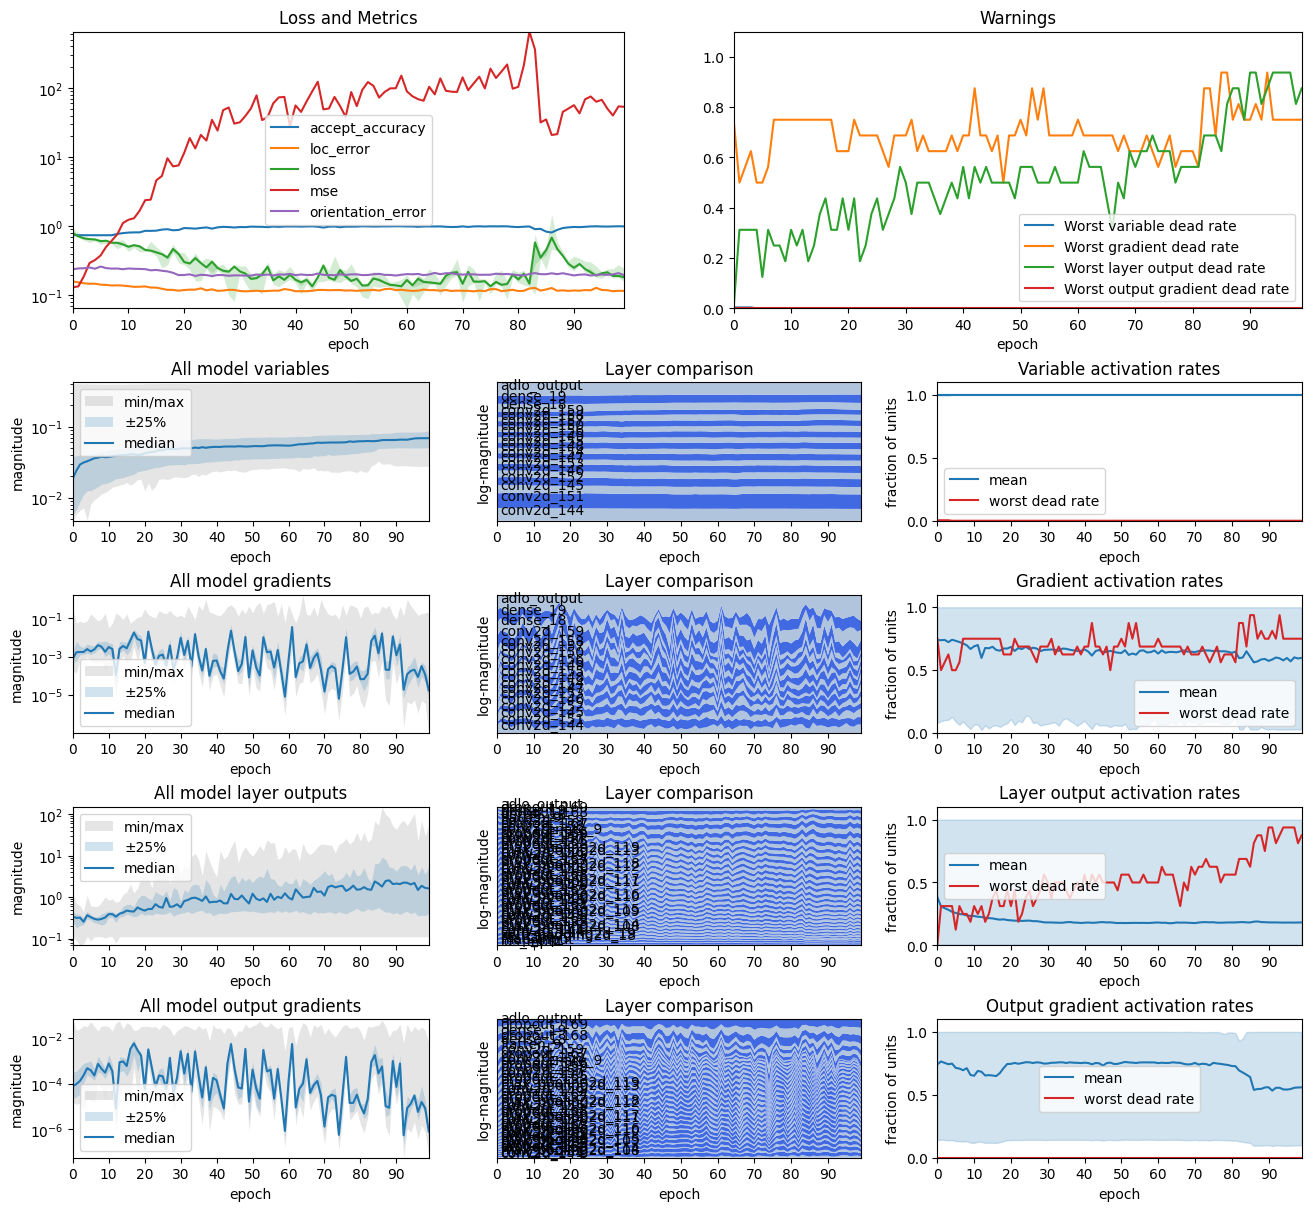

In [ ]:
reload(slam_models)
np.random.seed(42)
tf.random.set_seed(42)
epochs = 100
batch_size = 32
tf.config.run_functions_eagerly(False)
map_shape = next(iter(train_data))[0][0].shape
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)
model = adlo_model(map_shape, compile=True, dropout_rate=0.1, loss=ADLOLossSimple(from_logits=True, dlo_encoding='linear/linear'))

per_step=False
variables = tot.VariableHistoryCallback(per_step=per_step)
outputs = tot.LayerOutputHistoryCallback(per_step=per_step)
gradients = tot.GradientHistoryCallback(per_step=per_step)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=per_step)
model_history = tot.fit(model, model_train_data, epochs=epochs, verbose=0, callbacks=[variables, outputs, gradients, output_gradients, tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=per_step)])
tot.plot_history_overview([model_history, variables, gradients, outputs, output_gradients])

#model_history = tot.fit(model, model_train_data, epochs=epochs, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=per_step)])
#tot.plot_train_history(model_history)



## ChatGPT Prosed Solution
This still seems so bad, and the network itself is behaving badly.
In order to get something completely new, I'll start again from scratch with one proposed by ChatGPT.


Epoch     5 - 3.24s/epoch: loss: 0.3016  
Epoch    10 - 1.35s/epoch: loss: 0.0642  
Epoch    15 - 1.33s/epoch: loss: 0.0471  
Epoch    20 - 1.37s/epoch: loss: 0.0367  
Epoch    25 - 1.34s/epoch: loss: 0.0386  
Epoch    30 - 1.40s/epoch: loss: 0.0352  
Epoch    35 - 1.32s/epoch: loss: 0.0333  
Epoch    40 - 1.34s/epoch: loss: 0.0333  
Epoch    45 - 1.35s/epoch: loss: 0.0347  
Epoch    50 - 1.32s/epoch: loss: 0.0299  


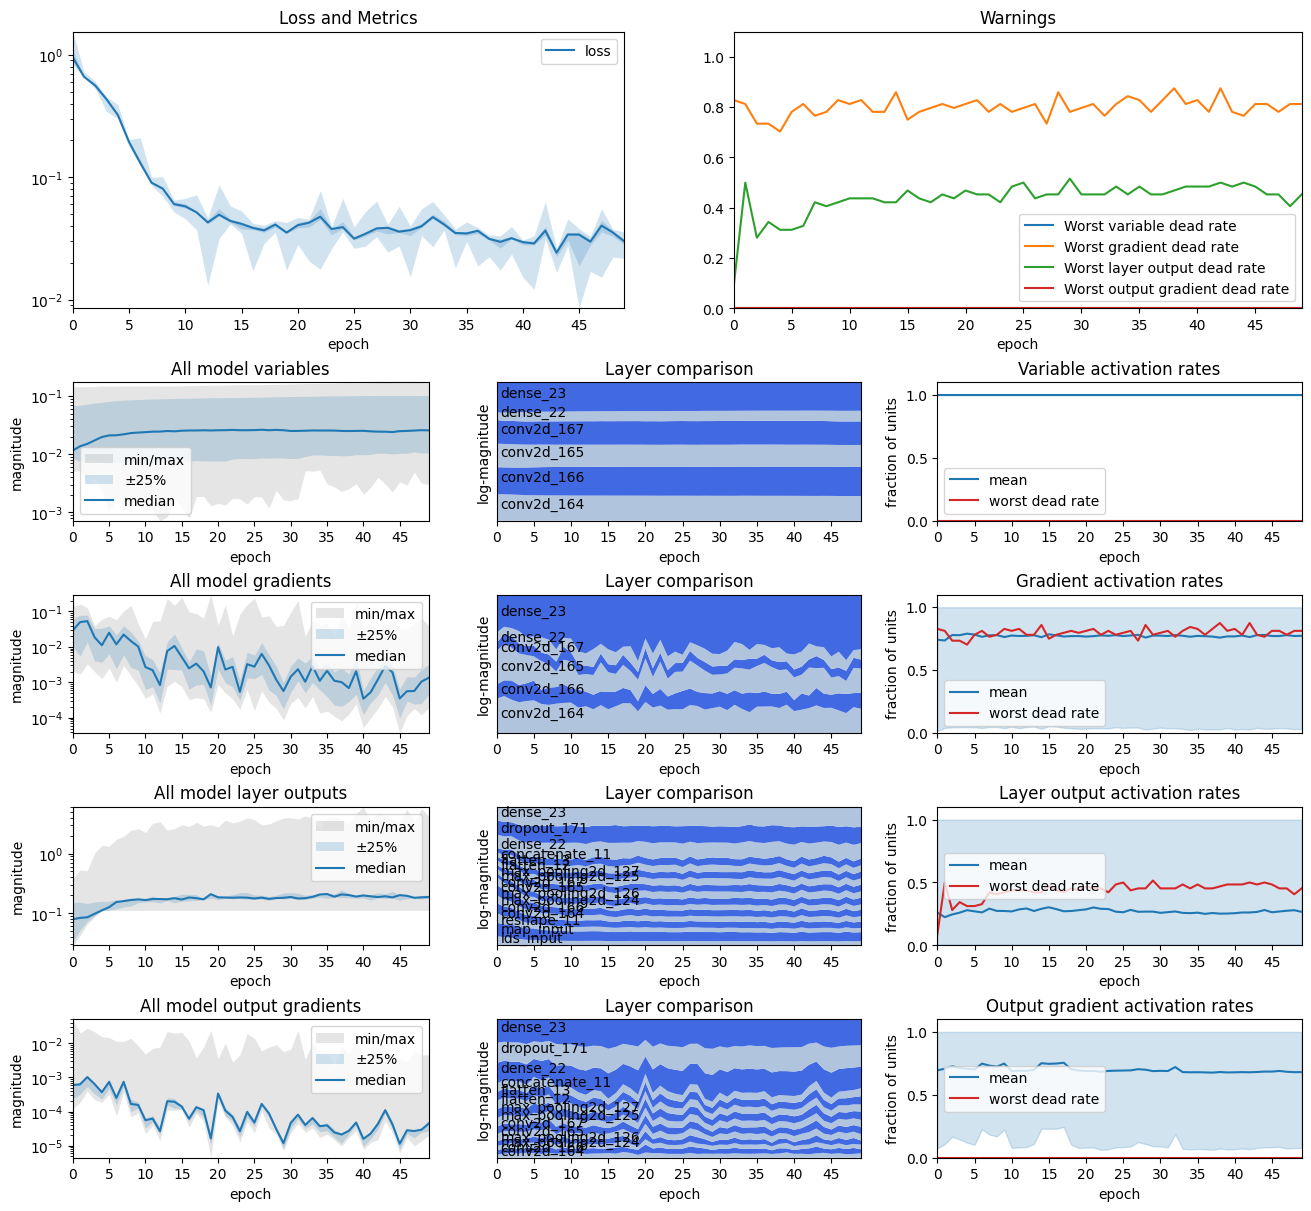

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_model():
    map_input = keras.Input(shape=(149, 149, 3), name="map_input")
    lds_input = keras.Input(shape=(149, 149), name="lds_input")
    lds_reshaped = layers.Reshape((149, 149, 1))(lds_input)

    # map tower
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(map_input)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)

    # lds tower
    y = layers.Conv2D(16, (3,3), activation='relu', padding='same')(lds_reshaped)
    y = layers.MaxPooling2D((2,2))(y)
    y = layers.Conv2D(32, (3,3), activation='relu', padding='same')(y)
    y = layers.MaxPooling2D((2,2))(y)
    y = layers.Flatten()(y)

    merged = layers.Concatenate()([x, y])
    merged = layers.Dense(64, activation='relu')(merged)
    merged = layers.Dropout(0.2)(merged)
    outputs = layers.Dense(4, activation='linear')(merged)
    return keras.Model(inputs=[map_input, lds_input], outputs=outputs)

def custom_adlo_loss(y_true, y_pred):
    accept_true = y_true[:, 0]
    dx_true = y_true[:, 1]
    dy_true = y_true[:, 2]
    dangle_true = y_true[:, 3]

    accept_logit = y_pred[:, 0]
    dx_logit = y_pred[:, 1]
    dy_logit = y_pred[:, 2]
    dangle_logit = y_pred[:, 3]

    # Classification loss (binary cross-entropy from logits)
    bce_per_example = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=accept_true, logits=accept_logit
    )
    accept_loss = tf.reduce_mean(bce_per_example)

    # Regression loss (masked by accept_true)
    dx_pred = 0.5 * tf.tanh(dx_logit)
    dy_pred = 0.5 * tf.tanh(dy_logit)
    dangle_pred = tf.tanh(dangle_logit)  # in [-1, 1]

    dx_mse = tf.square(dx_pred - dx_true)
    dy_mse = tf.square(dy_pred - dy_true)
    dangle_mse = tf.square(dangle_pred - dangle_true)

    mask = accept_true  # 1 if accept=1, 0 if accept=0
    reg_loss_per_example = (dx_mse + dy_mse + dangle_mse) * mask
    regression_loss = tf.reduce_mean(reg_loss_per_example)

    total_loss = accept_loss + regression_loss
    return total_loss

# Create the model
model = create_model()
model.compile(optimizer='adam', loss=custom_adlo_loss)

# Train
np.random.seed(42)
tf.random.set_seed(42)
epochs = 50
batch_size = 32
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

per_step=False
variables = tot.VariableHistoryCallback(per_step=per_step)
outputs = tot.LayerOutputHistoryCallback(per_step=per_step)
gradients = tot.GradientHistoryCallback(per_step=per_step)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=per_step)
model_history = tot.fit(model, model_train_data, epochs=epochs, verbose=0, callbacks=[variables, outputs, gradients, output_gradients, tot.LessVerboseProgressLogger(), tot.HistoryStats(per_step=per_step)])
tot.plot_history_overview([model_history, variables, gradients, outputs, output_gradients])


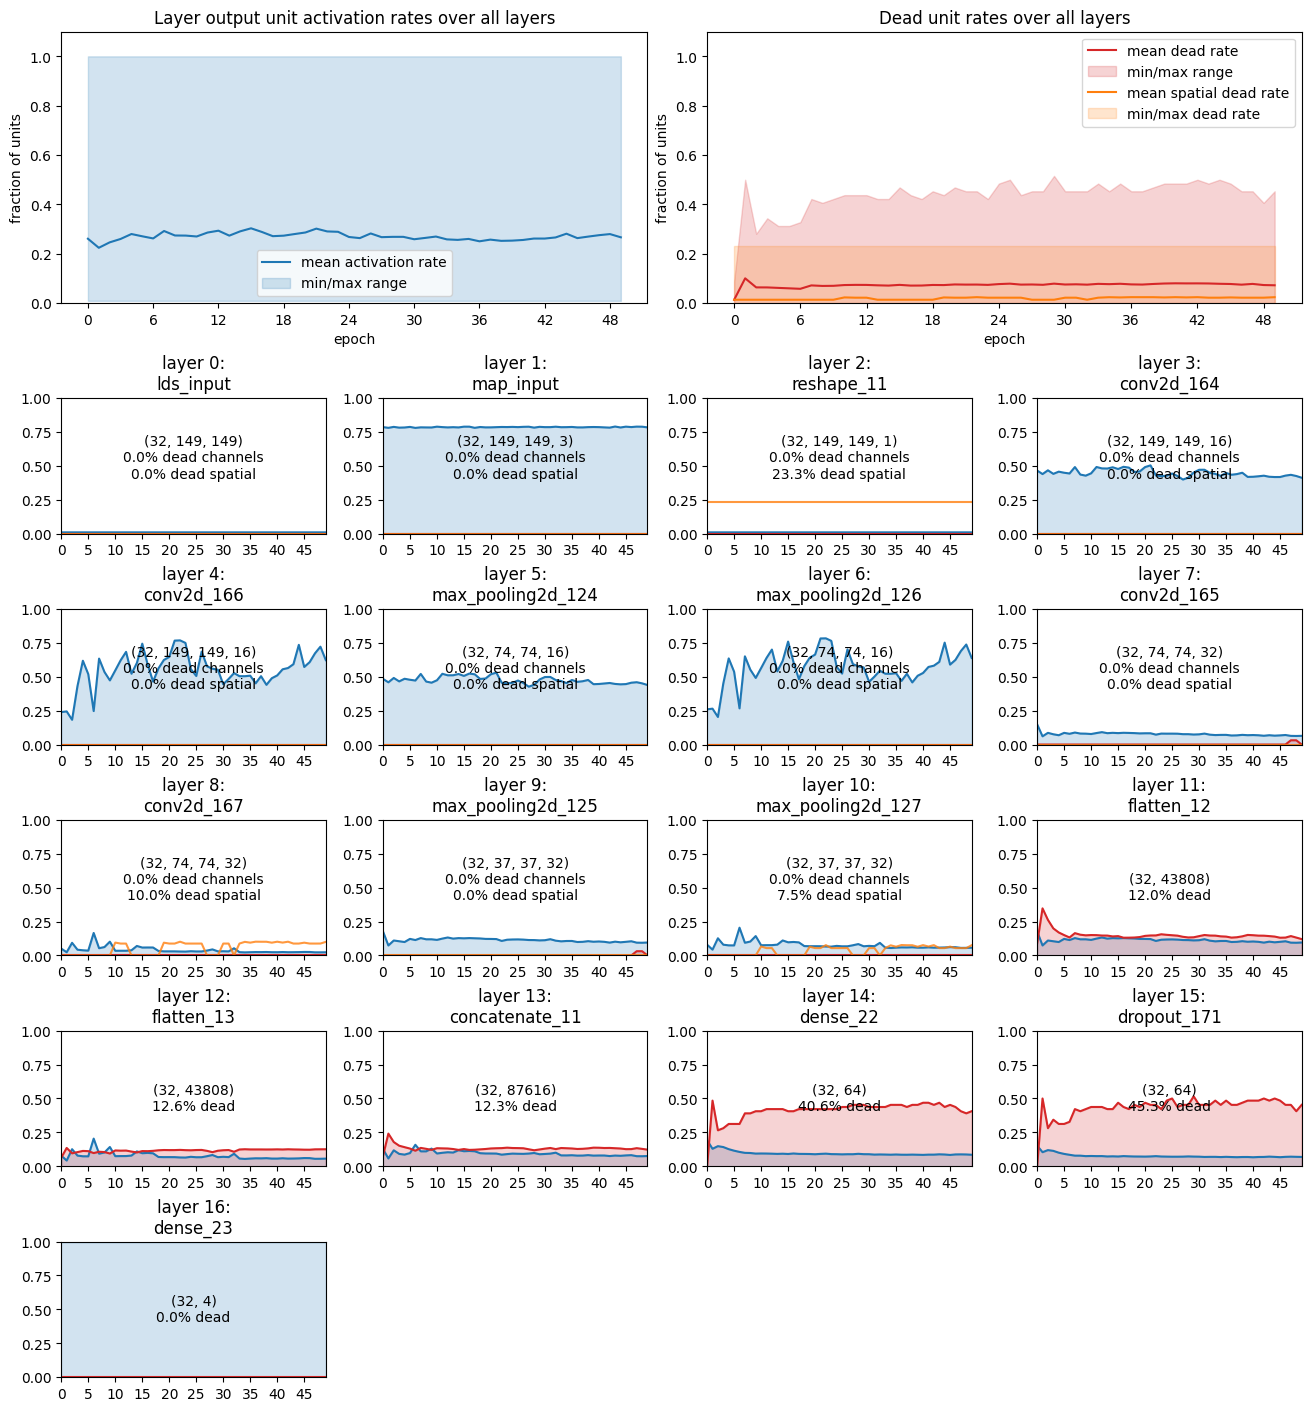

In [ ]:
tot.plot_activity_history(outputs)